# Linear Regression Model for Ozone Level in Denver, Colorado

Most of us probably remember learning about the protection that the ozone layer in the upper atmosphere lends us. However, ground level ozone has well documented negative effects. Those with Asthma are particularly at risk to it [[1]](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics). Denver has one of the worst levels of ground level ozone in the united states [[2]](https://www.denverpost.com/2021/06/16/denver-fortcollins-worst-cities-air-pollution/). It is well known that ozone is greatly affected by pollutants emitted by cars, power plants, refineries, etc. in the presence of sunlight [[3]](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics#:~:text=This%20happens%20when%20pollutants%20emitted,high%20levels%20during%20colder%20months.). 

**Goal**: To develop a reasonably accurate linear, polynomial, and ridge polynomial regression model to predict the amount of ozone in the air. 

**Results**: Using historical weather data paired with EPA data on ozone pollutant a fifth degree polynomial regression model with R^2 of 0.76 and a MAE  of .0064 and RMSE .0085 ppm on the test set is developed. There is some amount of overfitting on the training set with the data, as the MAE and RMSE on the training set are .054 and .069 respectively. However, this overfitting is relatively mild and ridge regression does not appear to do any better on the test set.

Possible extensions: A couple improvements I'd like to make is I'd like to capture the tail of this distribution better. The model could be built to more heavily penalize inaccuracies in the higher end of the ozone range, to attempt to be a more conservative predictor. I think that importing a custom loss function to penalize the error made at higher ozone levels could be helpful here. 

[Ozone Data](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

[Worst Ranking Ozone Levels](https://www.lung.org/research/sota/city-rankings/most-polluted-cities)

[Historical Weather Data](https://visualcrossing.com/)

[Weather Data Documentation](https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/)

[Effect of Weekends](https://www.tandfonline.com/doi/full/10.1080/10962247.2012.749312#:~:text=In%20simple%20terms%2C%20the%20ozone,NOx\)%2C%20on%20weekends.)

# Utilities, Constants

In [109]:
def calculate_percent_missing(in_df):
    # function which returns a dataframe indicating what percent of a column is missing
    percent_missing = in_df.isnull().sum() * 100 / len(in_df)
    return pd.DataFrame({'percent_missing': percent_missing})

TEST_FRACTION = .25 #percentage of the test size
CV = 7 #cross validations to do in grid search
N_JOBS = 7 #number of cores
RAND_STATE = 0 #will be doing multiple train-test-splits, and want to keep everything random, but do the same train-test-splits

In [110]:
def get_poly_scaled(df, numerical_cols, cat_cols, target_col, n_deg):
    """ Takes in a data set, the numerical columns you are interested in, and categorical columns and degree and returns 
    the scaled numerical dataset with with polynomial features of degree n_deg, the categorical columns, and the target columns all properly indexed
    Args:
    in_df: dataframe
    numerical_cols: numerical column names, list
    cat_cols: categorical column names, list
    target: target name, string
    n_deg: integer, the degree
    """
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #scaling the parameters
    ss = StandardScaler()
    poly = PolynomialFeatures(n_deg)
    in_df = df.reset_index()
    #Ensure the index is set from 0 to n-1, since poly.fit_transform will return a dataframe and we'll have unmatched indices if we do not do this
    #in_df.reset_index(inplace=True)
    
    # Categorize the types of features and target
    df_num = in_df[numerical_cols]
    df_cat = in_df[cat_cols]
    y = in_df[target_col]
    #Transform
    use_poly = poly.fit_transform(df_num)
    df_poly = pd.DataFrame(use_poly)
    
    # Set column names
    df_poly.columns = poly.get_feature_names(df_num.columns)
    df_scaled_poly = pd.DataFrame(ss.fit_transform(df_poly), index=df_poly.index, columns=df_poly.columns)
    return (df_scaled_poly, df_cat, y)

def get_mae(reg, X, y):
    """ returns the mean average error of the regressor reg on X """
    y_pred = reg.predict(X)
    abs_err = np.abs(y_pred - y)
    return abs_err.mean()

def get_rmse(reg, X, y):
    """ returns the root mean square error of the regressor reg on X """
    y_pred = reg.predict(X)
    sqr_err = np.power(y_pred - y, 2)
    mse = np.mean(sqr_err)
    return np.sqrt(mse)

def print_errors(reg, X, y):
    """ prints mae and rmse """
    print("MAE: {:.4f} \nRMSE: {:.4f}".format(get_mae(reg, X, y), get_rmse(reg, X, y)))

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Exploring the Data and Creating Features


## Parameters and useful functions for analysis

In [112]:
# Ozone and Weather Data
df = pd.read_csv('data/ozone_2019.csv')
df_col_weather = pd.read_csv('data/denver_weather_2019.csv')

/home/jcummings/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [113]:
# Going to lower case columns, check out the data. Nothing super surprising here in the summary statistics.
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.describe()

,state code,county code,site num,parameter code,poc,latitude,longitude,sample measurement,mdl,uncertainty,method code
count,9.142786e+06,9.142786e+06,9.142786e+06,9142786.0,9.142786e+06,9.142786e+06,9.142786e+06,9.142786e+06,9.142786e+06,0.0,9.142786e+06
mean,2.668803e+01,7.627163e+01,1.344786e+03,44201.0,1.084851e+00,3.758337e+01,-9.520775e+01,3.078728e-02,1.397212e-01,NaN,7.220774e+01
std,1.684961e+01,8.080285e+01,2.670646e+03,0.0,3.483333e-01,4.926934e+00,1.619993e+01,1.481152e-02,8.220645e-01,NaN,4.150573e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,44201.0,1.000000e+00,1.821604e+01,-1.580886e+02,-4.000000e-03,6.000000e-04,NaN,1.900000e+01
25%,1.000000e+01,2.300000e+01,6.000000e+00,44201.0,1.000000e+00,3.406957e+01,-1.101827e+02,2.100000e-02,5.000000e-03,NaN,4.700000e+01
50%,2.600000e+01,5.900000e+01,2.500000e+01,44201.0,1.000000e+00,3.835655e+01,-9.121356e+01,3.100000e-02,5.000000e-03,NaN,8.700000e+01
75%,4.200000e+01,1.030000e+02,1.015000e+03,44201.0,1.000000e+00,4.095960e+01,-8.213125e+01,4.100000e-02,5.000000e-03,NaN,8.700000e+01
max,8.000000e+01,8.000000e+02,9.997000e+03,44201.0,6.000000e+00,6.484569e+01,-6.612653e+01,1.600000e-01,8.000000e+00,NaN,9.010000e+02


In [114]:
df.columns

Index(['state code', 'county code', 'site num', 'parameter code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter name', 'date local',
       'time local', 'date gmt', 'time gmt', 'sample measurement',
       'units of measure', 'mdl', 'uncertainty', 'qualifier', 'method type',
       'method code', 'method name', 'state name', 'county name',
       'date of last change'],
      dtype='object')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9142786 entries, 0 to 9142785
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   state code           int64  
 1   county code          int64  
 2   site num             int64  
 3   parameter code       int64  
 4   poc                  int64  
 5   latitude             float64
 6   longitude            float64
 7   datum                object 
 8   parameter name       object 
 9   date local           object 
 10  time local           object 
 11  date gmt             object 
 12  time gmt             object 
 13  sample measurement   float64
 14  units of measure     object 
 15  mdl                  float64
 16  uncertainty          float64
 17  qualifier            object 
 18  method type          object 
 19  method code          int64  
 20  method name          object 
 21  state name           object 
 22  county name          object 
 23  date of last change  object 
dty

In [116]:
# We are interested in getting Denver, Colorado's data
df_col_oz = df.loc[(df['county name']=='Denver') & (df['state name']=='Colorado')]

<AxesSubplot:xlabel='sample measurement', ylabel='Count'>

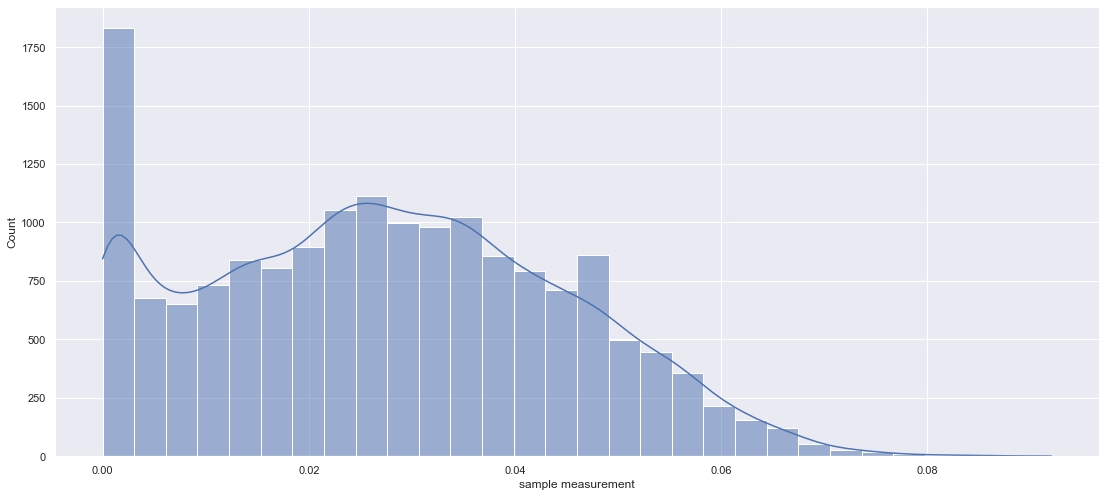

In [117]:
# Taking a peek at the histogram. Note the spike in the count at 0
sns.histplot(df_col_oz['sample measurement'], kde = True, bins=30)

In [118]:
# Checking the data
df_col_oz.head()

,state code,county code,site num,parameter code,poc,latitude,longitude,datum,parameter name,date local,...,units of measure,mdl,uncertainty,qualifier,method type,method code,method name,state name,county name,date of last change
1999057,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999058,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999059,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999060,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999061,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15


In [119]:
# Checking the latitudes of the stations in Denver to see if there are multiple
# There are, and in the next few lines we only consider data from the station with the most dates of observation
df_col_oz['latitude'].unique()

array([39.751184, 39.77949 ])

In [120]:
len(df_col_oz.loc[df_col_oz['latitude']==39.77949, 'date local'])

8087

In [121]:
len(df_col_oz.loc[df_col_oz['latitude']==39.751184, 'date local'])

8639

In [122]:
# Going to use the station with slightly more readings
df_col_oz = df_col_oz[df_col_oz['latitude']==39.751184]

In [123]:
df_col_oz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8639 entries, 1999057 to 2007695
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state code           8639 non-null   int64  
 1   county code          8639 non-null   int64  
 2   site num             8639 non-null   int64  
 3   parameter code       8639 non-null   int64  
 4   poc                  8639 non-null   int64  
 5   latitude             8639 non-null   float64
 6   longitude            8639 non-null   float64
 7   datum                8639 non-null   object 
 8   parameter name       8639 non-null   object 
 9   date local           8639 non-null   object 
 10  time local           8639 non-null   object 
 11  date gmt             8639 non-null   object 
 12  time gmt             8639 non-null   object 
 13  sample measurement   8639 non-null   float64
 14  units of measure     8639 non-null   object 
 15  mdl                  8639 non

In [124]:
# Checking some columns, these are not useful
df_col_oz['mdl'].unique()

array([0.005])

In [125]:
df_col_oz['qualifier'].unique()

array([nan], dtype=object)

In [126]:
# Only a few columns will be used from the ozone data set: the time date and ozone measurement
useful_cols = ['date local', 'time local', 'sample measurement']
df_col_oz = df_col_oz[useful_cols]

In [127]:
df_col_oz.head()

,date local,time local,sample measurement
1999057,2019-01-01,00:00,0.013
1999058,2019-01-01,01:00,0.016
1999059,2019-01-01,02:00,0.016
1999060,2019-01-01,03:00,0.021
1999061,2019-01-01,04:00,0.023


In [128]:
# Going to join on the ate and time of the weather and ozone data, setting this up.
df_col_weather['datetime_dt'] = pd.to_datetime(df_col_weather['datetime'])
df_col_weather['datetime_dt']

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime_dt, Length: 17544, dtype: datetime64[ns]

In [129]:
# Need a seconds measurement so I can join on the format of the weather datetime column
df_col_oz['datetime'] = df_col_oz['date local'] + ' ' + df_col_oz['time local'] + ':00'
df_col_oz

,date local,time local,sample measurement,datetime
1999057,2019-01-01,00:00,0.013,2019-01-01 00:00:00
1999058,2019-01-01,01:00,0.016,2019-01-01 01:00:00
1999059,2019-01-01,02:00,0.016,2019-01-01 02:00:00
1999060,2019-01-01,03:00,0.021,2019-01-01 03:00:00
1999061,2019-01-01,04:00,0.023,2019-01-01 04:00:00
...,...,...,...,...
2007691,2019-12-31,19:00,0.002,2019-12-31 19:00:00
2007692,2019-12-31,20:00,0.003,2019-12-31 20:00:00
2007693,2019-12-31,21:00,0.011,2019-12-31 21:00:00
2007694,2019-12-31,22:00,0.022,2019-12-31 22:00:00


In [130]:
# Convert to datetime object
df_col_oz['datetime'] = pd.to_datetime(df_col_oz['datetime'])

In [131]:
df_col_oz['datetime']

1999057   2019-01-01 00:00:00
1999058   2019-01-01 01:00:00
1999059   2019-01-01 02:00:00
1999060   2019-01-01 03:00:00
1999061   2019-01-01 04:00:00
                  ...        
2007691   2019-12-31 19:00:00
2007692   2019-12-31 20:00:00
2007693   2019-12-31 21:00:00
2007694   2019-12-31 22:00:00
2007695   2019-12-31 23:00:00
Name: datetime, Length: 8639, dtype: datetime64[ns]

In [132]:
df_col = df_col_oz.merge(df_col_weather, left_on='datetime', right_on='datetime_dt', suffixes=('_oz', '_weather'), how='left')

In [133]:
# Will want to examine the relationship between the day of week and ozone.
df_col['day_of_week'] = df_col['datetime_dt'].dt.dayofweek

In [134]:
# Also if it is a weekday
df_col['type of day'] = 'weekday'
weekend_mask = ((df_col['day_of_week']==5) | (df_col['day_of_week']==6))
df_col.loc[weekend_mask, 'type of day'] = 'weekend'

In [135]:
# Weekends have higher ozone levels. There is some information in the links at the beginning of the notebook about this.
df_col.groupby('type of day').agg({'sample measurement': 'mean'})

,sample measurement
type of day,
weekday,0.025862
weekend,0.030961


In [136]:
# I'm not sure what to make of "Rain, Partially cloudy" vs "Rain, Overcast" here.
df_col.groupby('conditions').agg({'sample measurement': ['mean', 'count']})

sample measurement      
                                     mean count
conditions                                     
Clear                            0.018760  1056
Overcast                         0.018964   306
Partially cloudy                 0.029132  6847
Rain, Overcast                   0.017875    24
Rain, Partially cloudy           0.034946   185
Snow, Overcast                   0.017460    50
Snow, Partially cloudy           0.018608   171

In [137]:
# Examining temporal dependence of ozone on the hour and month
df_col['hour'] = df_col['datetime_dt'].dt.hour
df_col.groupby('hour').agg({'sample measurement': ['mean']})

,sample measurement
,mean
hour,
0.0,0.018352
1.0,0.022080
2.0,0.021833
3.0,0.020654
4.0,0.018606
5.0,0.015939
6.0,0.014978
7.0,0.017139


<AxesSubplot:xlabel='hour', ylabel='sample measurement'>

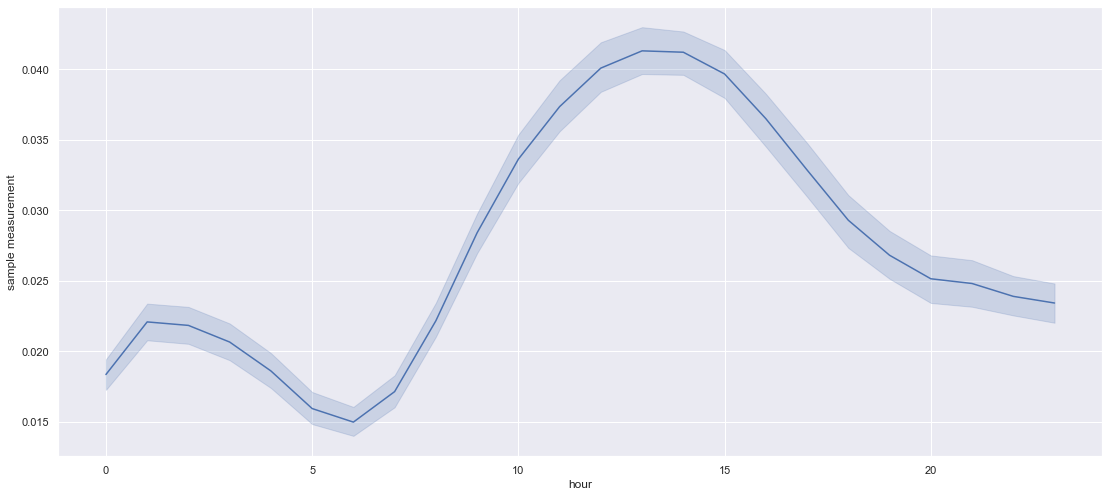

In [138]:
sns.lineplot(data = df_col, x='hour', y='sample measurement')

In [139]:
# Going to create a cyclic variable to measure the hour, as there looks 
# to be strong dependence here, likely due to warmth and car traffic
df_col['hour_x'] = np.cos(np.pi/12.0*df_col['hour'])
df_col['hour_y'] = np.sin(np.pi/12.0*df_col['hour'])

In [140]:
df_col['month'] = df_col['datetime_dt'].dt.month
df_col.groupby('month').agg({'sample measurement': 'mean'})

,sample measurement
month,
1.0,0.015444
2.0,0.016525
3.0,0.026470
4.0,0.032462
5.0,0.031878
6.0,0.039393
7.0,0.039472
8.0,0.040916
9.0,0.032408


In [141]:
# The month seems to be important, let's parameterize it cyclicly
df_col['month_x'] = np.cos(np.pi/6.0*df_col['month'])
df_col['month_y'] = np.sin(np.pi/6.0*df_col['month'])

<AxesSubplot:xlabel='cloudcover', ylabel='Count'>

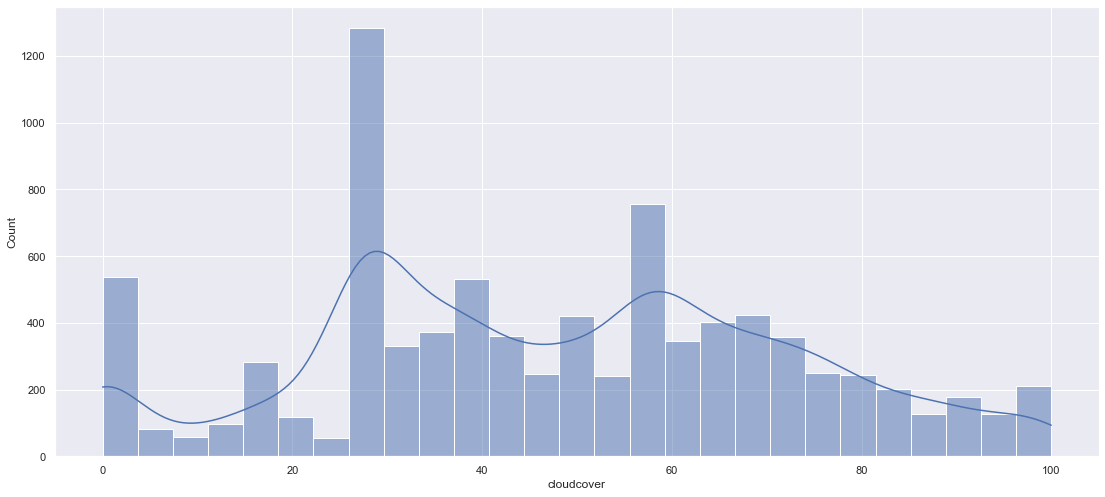

In [142]:
# GOing to ignore this feature
sns.histplot(df_col['cloudcover'], kde=True)

In [143]:
# Not used, only 0 or nan
df_col['uvindex'].unique()

array([ 0., nan])

In [144]:
# Many observations in each month with a high ozone level.
THRESH = .04
ozone_high_mask = df['sample measurement']>THRESH
df_col['high ozone']=0.0
df_col.loc[ozone_high_mask, 'high ozone']=1.0
df_col.groupby('month').agg({'high ozone': sum})

,high ozone
month,
1.0,267.0
2.0,273.0
3.0,224.0
4.0,150.0
5.0,147.0
6.0,130.0
7.0,150.0
8.0,57.0
9.0,258.0


/home/jcummings/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


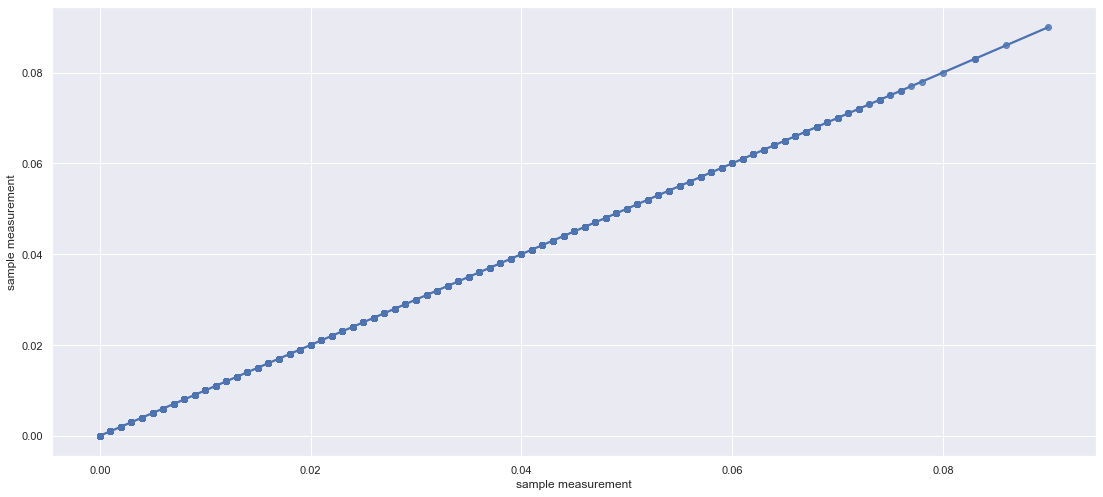

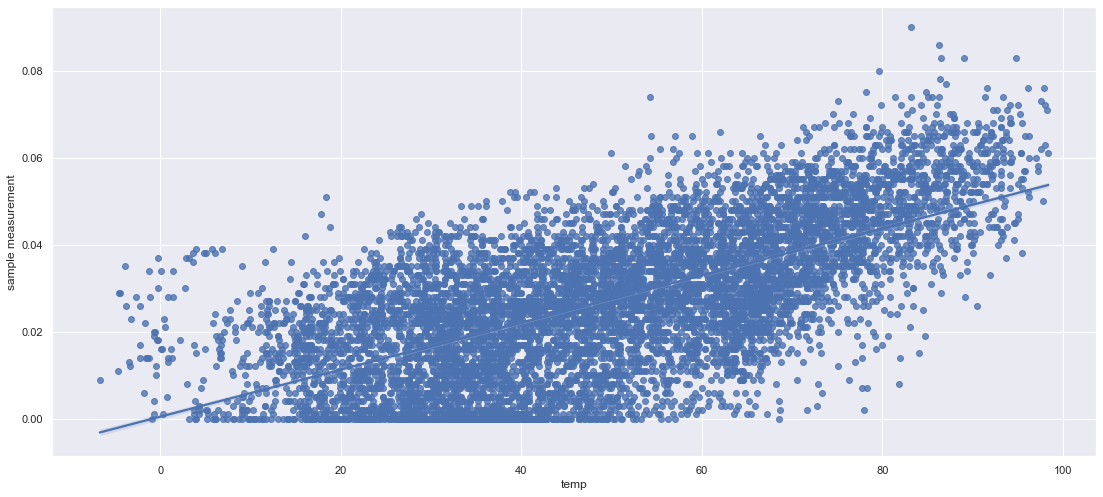

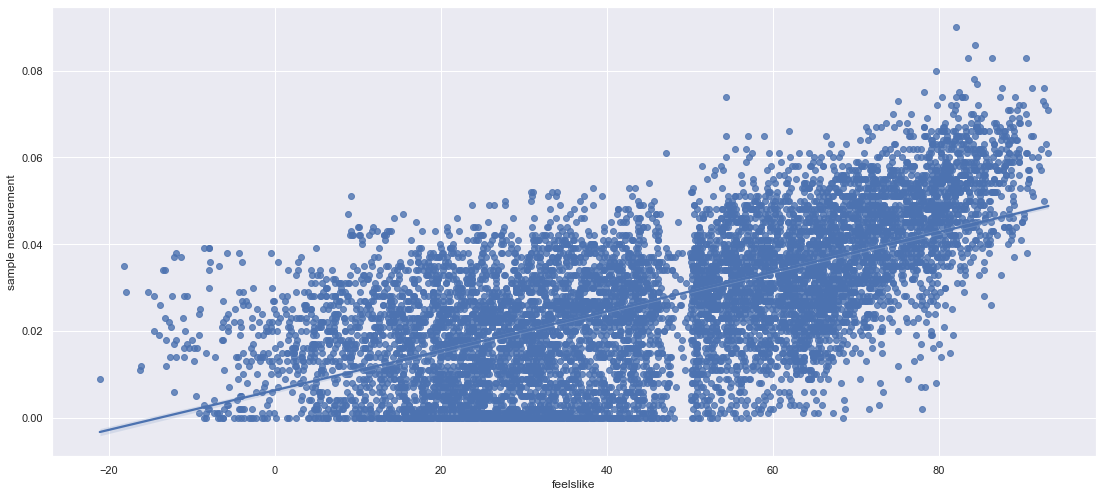

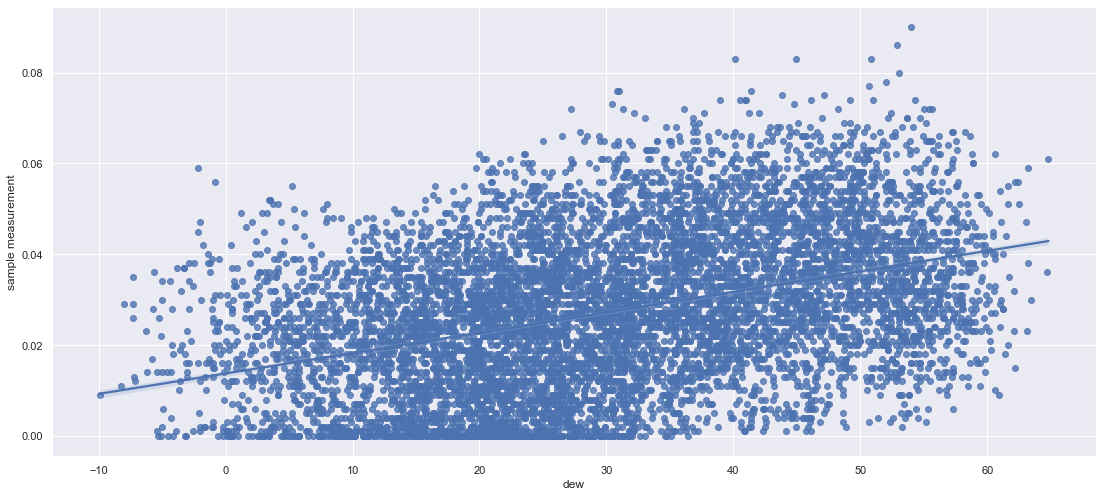

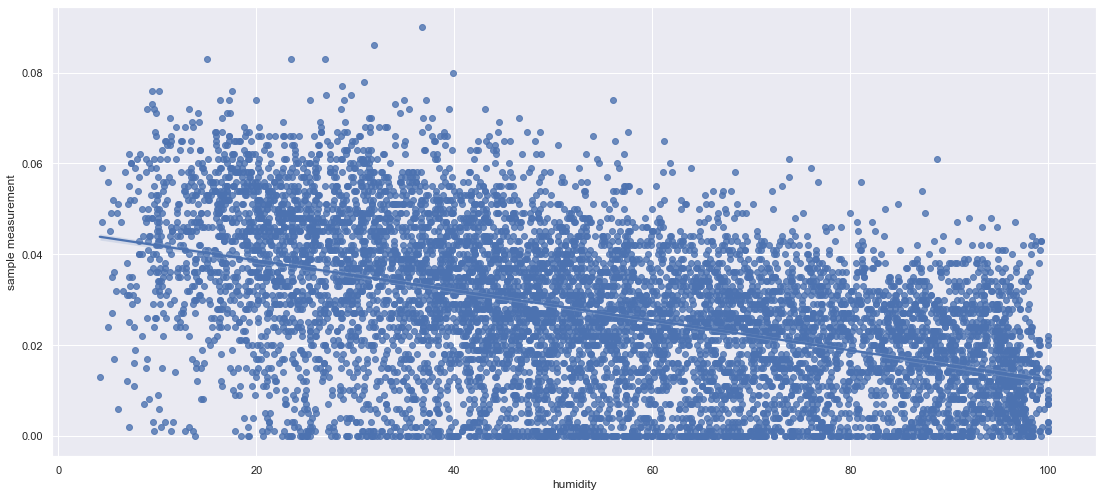

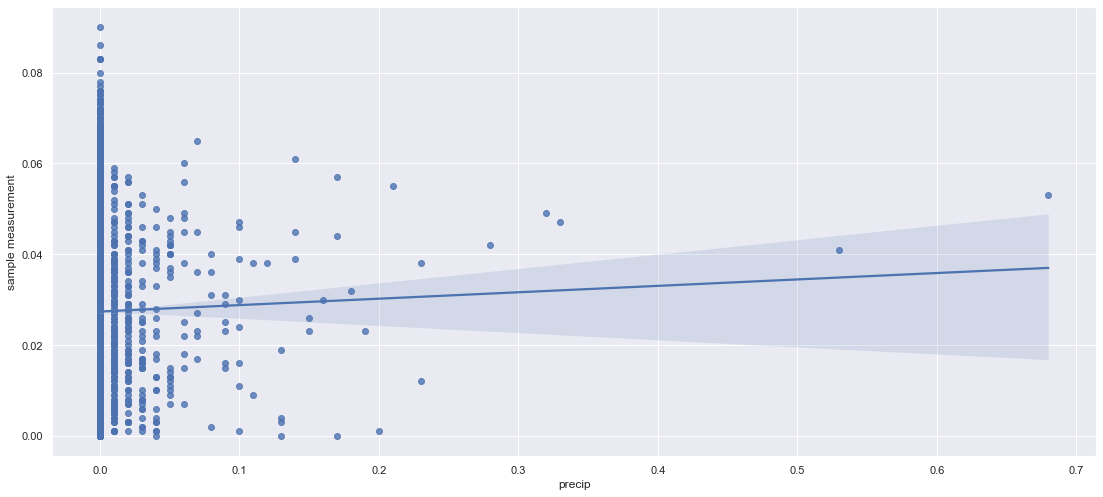

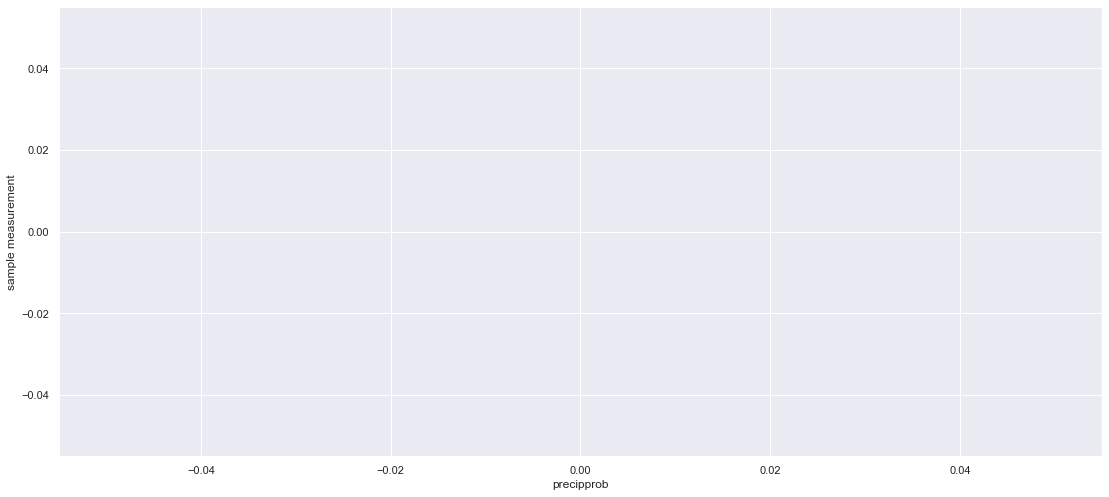

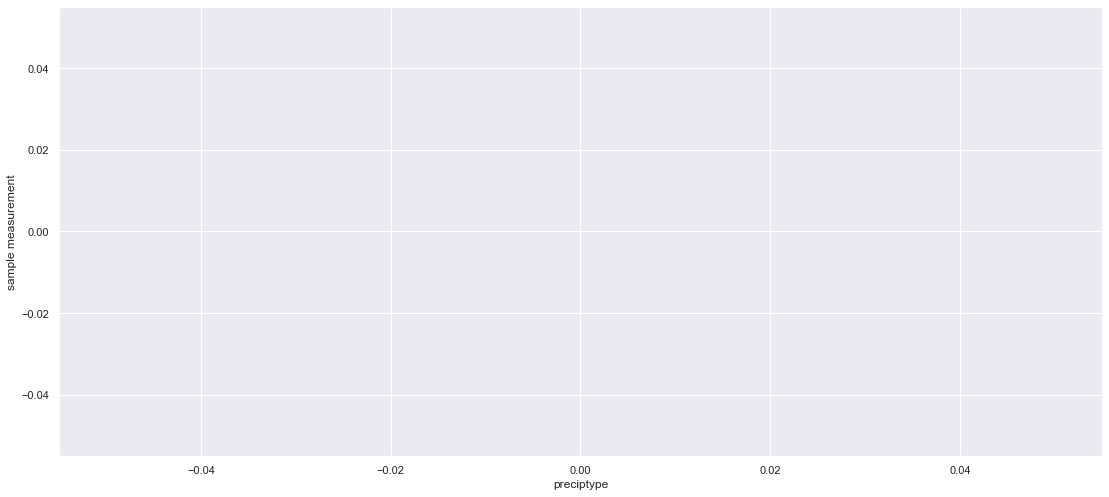

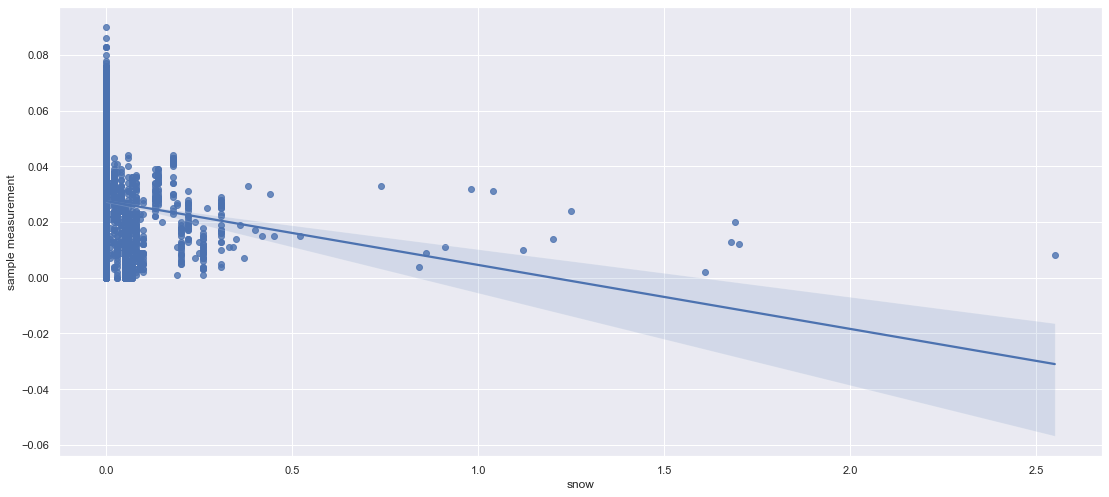

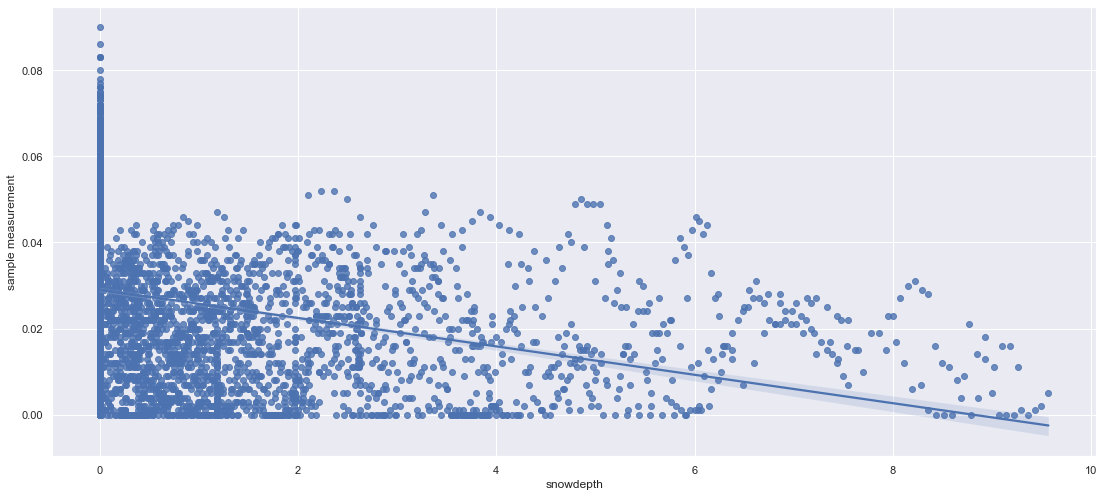

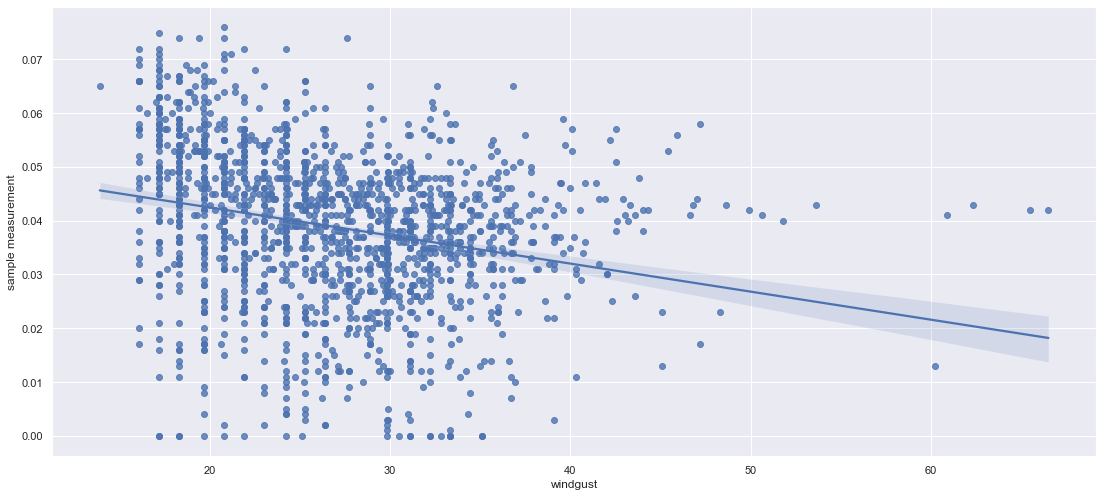

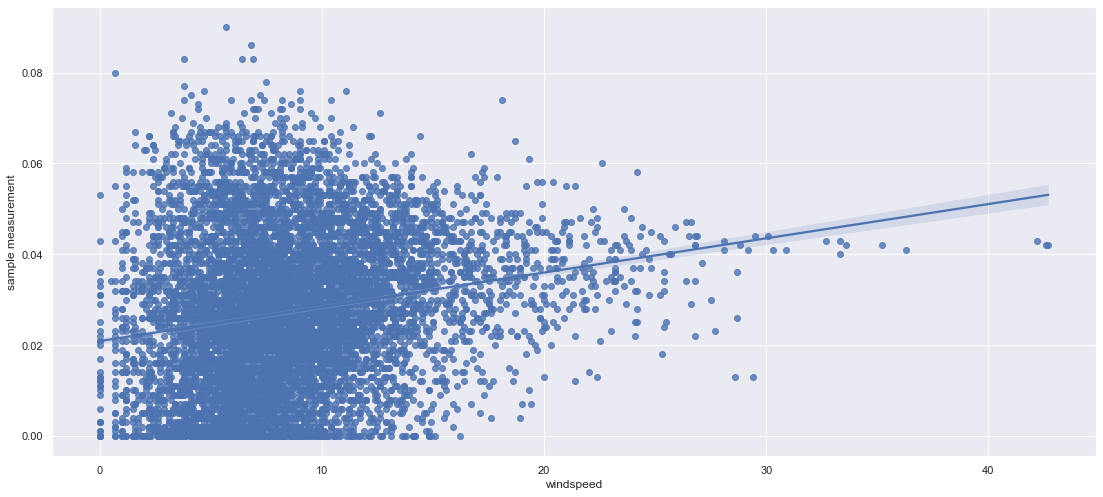

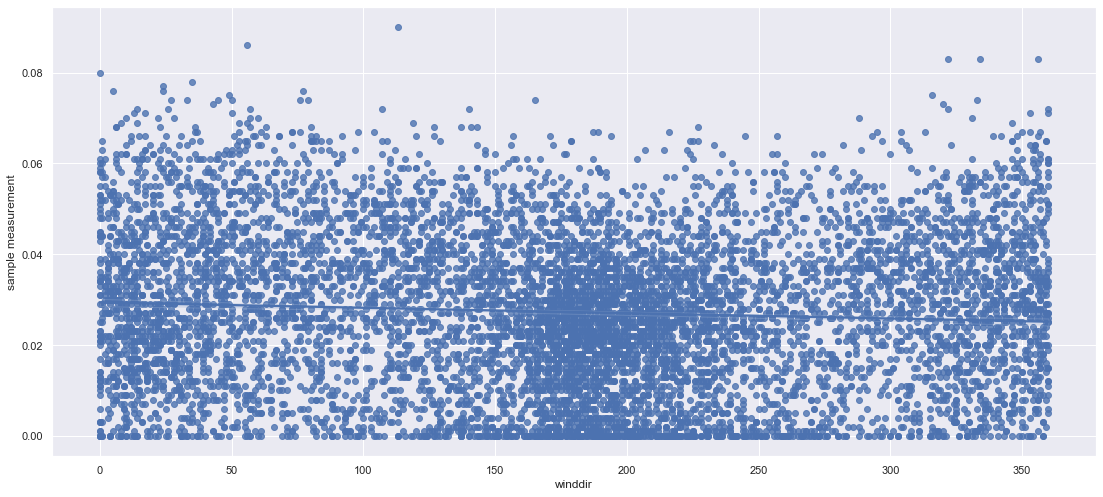

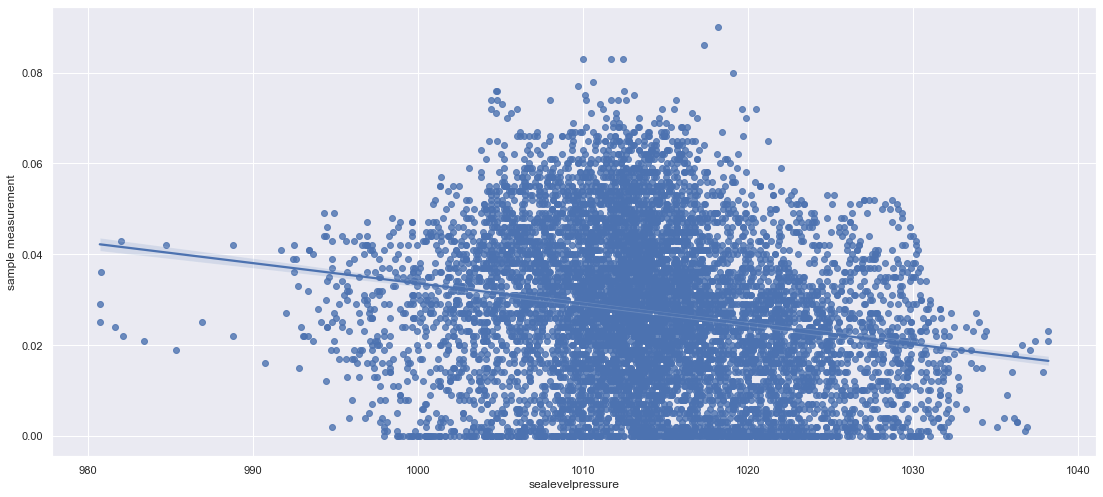

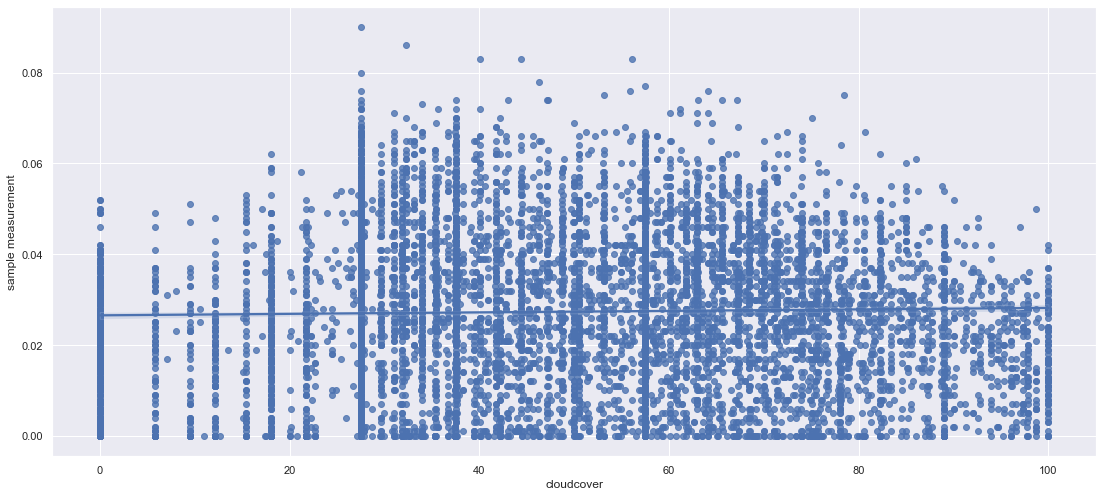

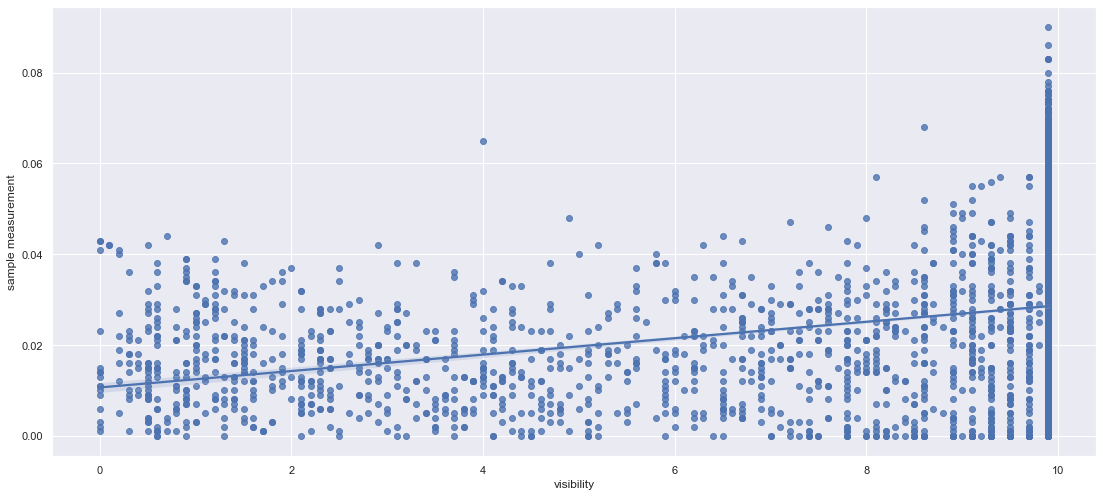

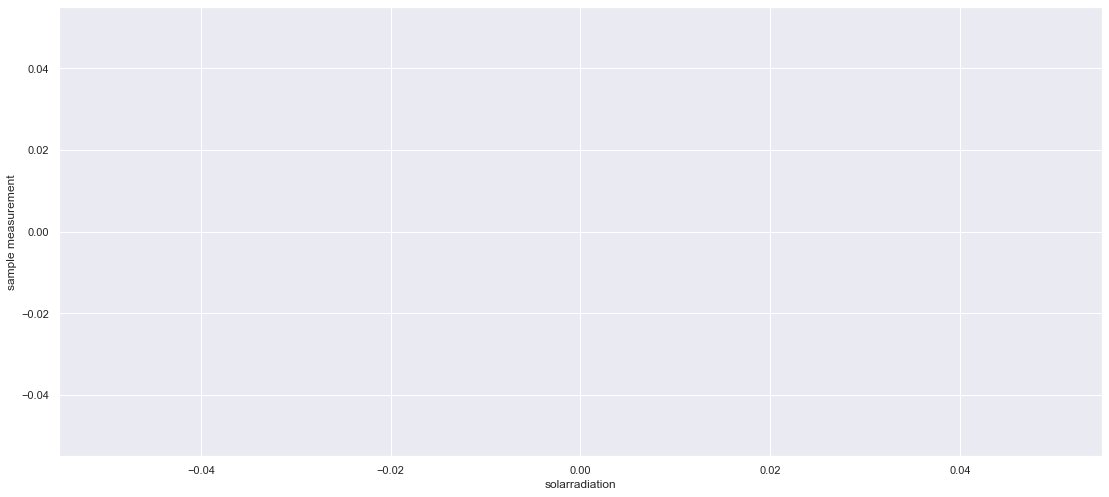

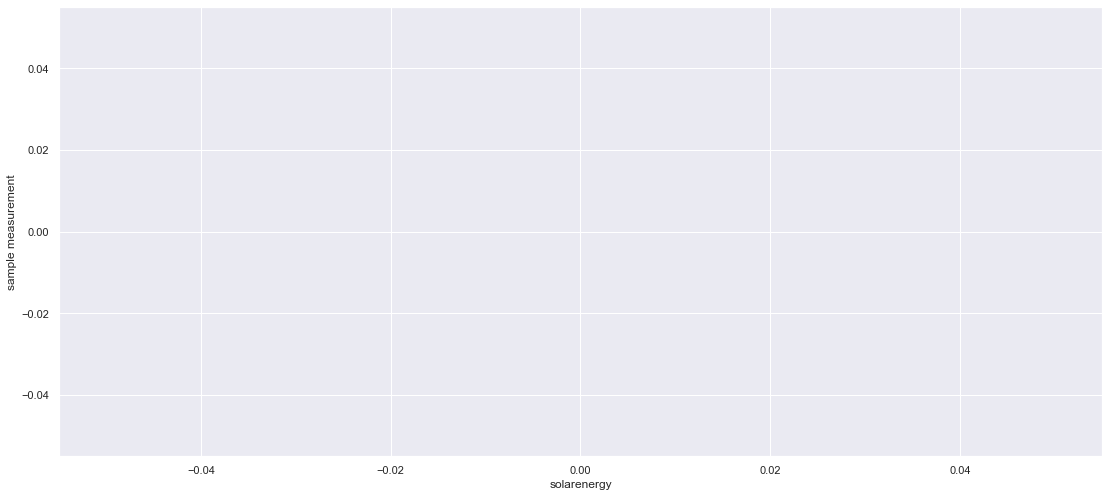

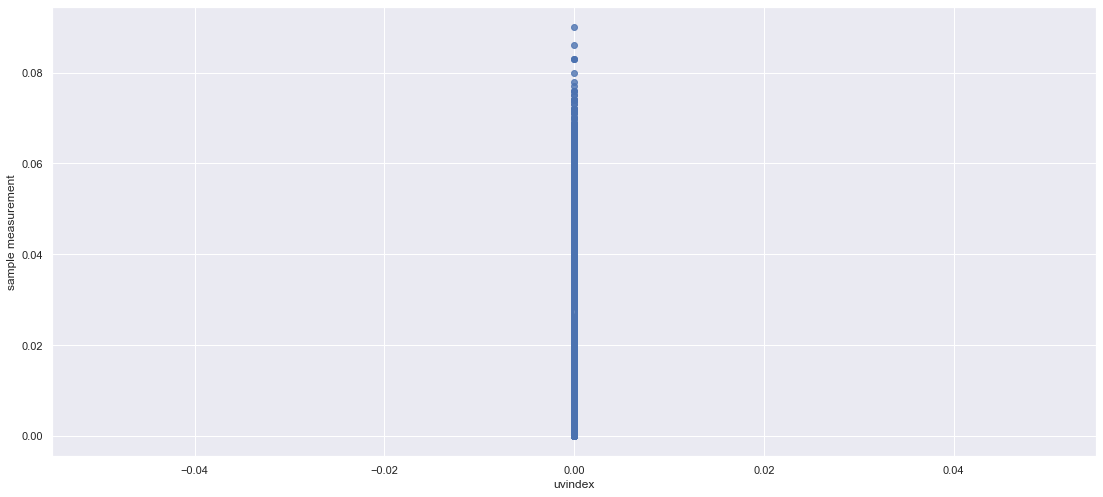

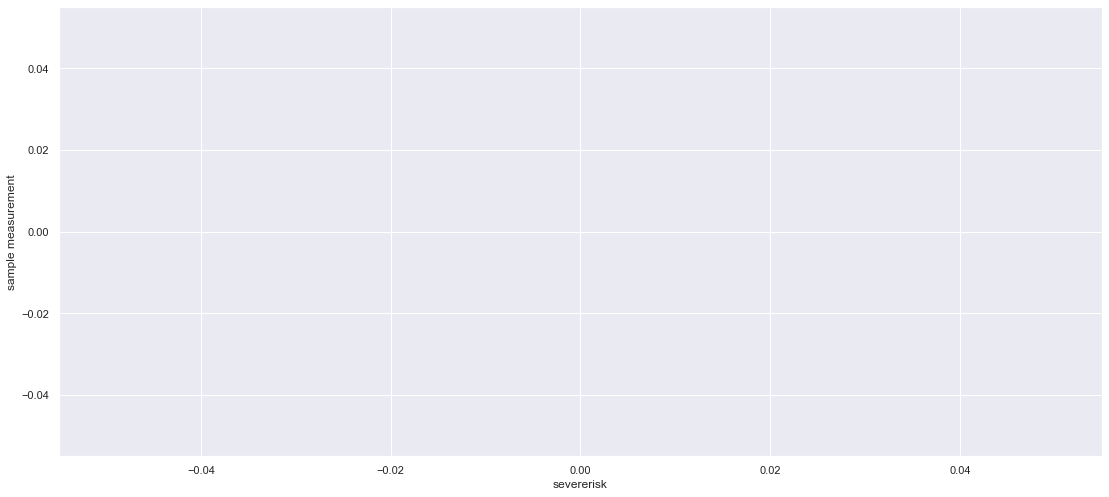

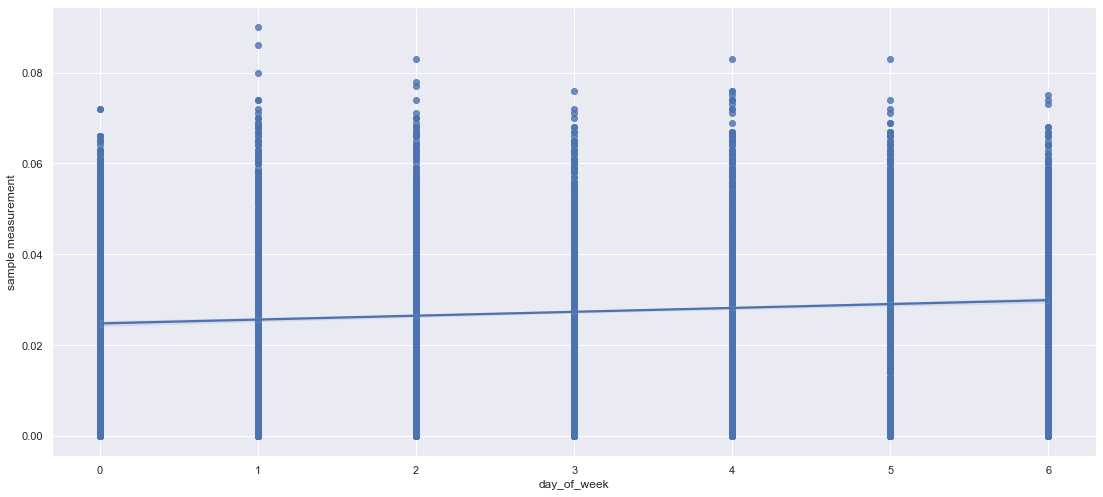

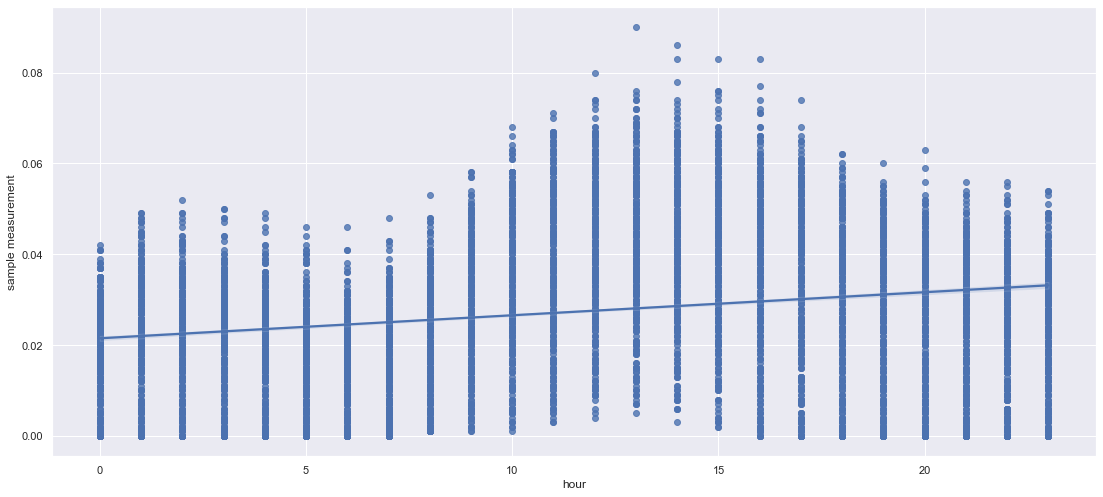

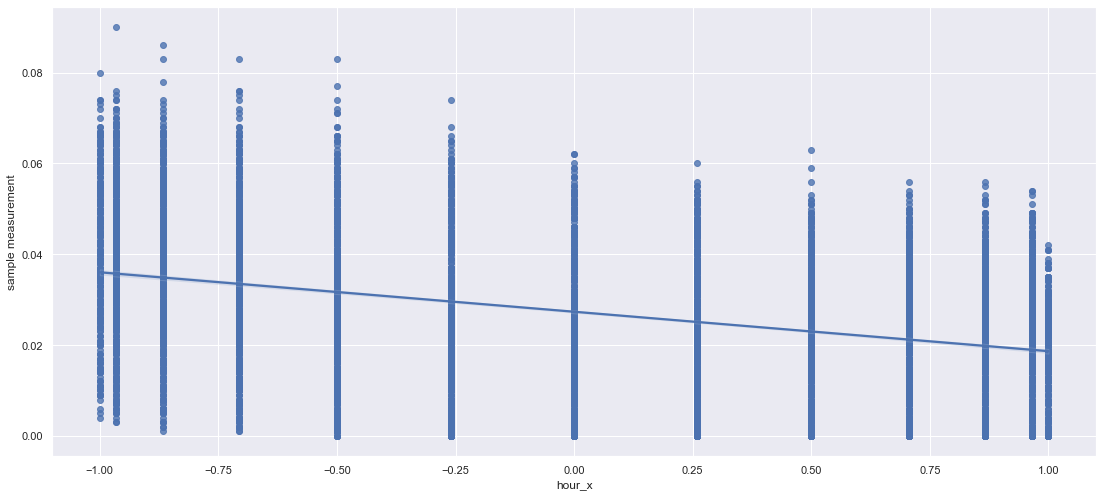

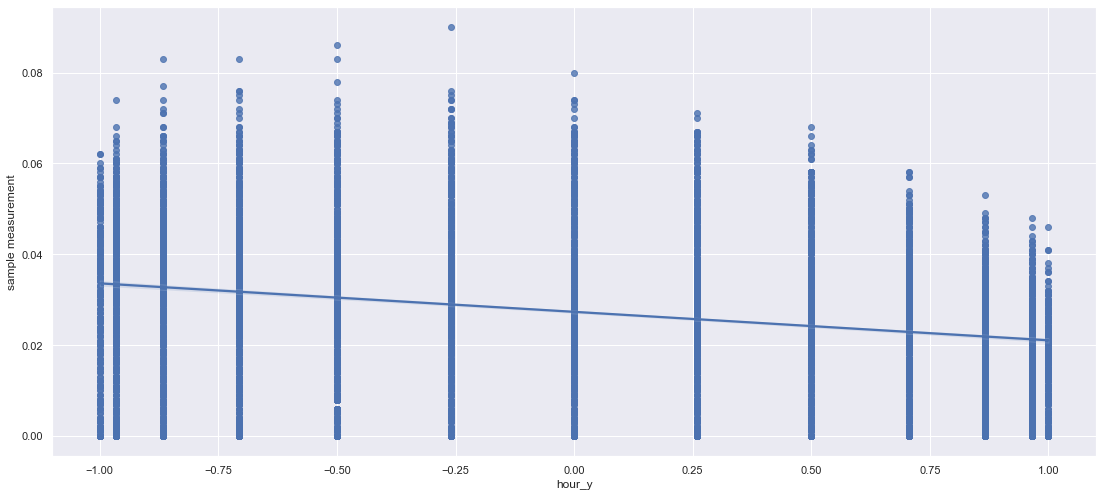

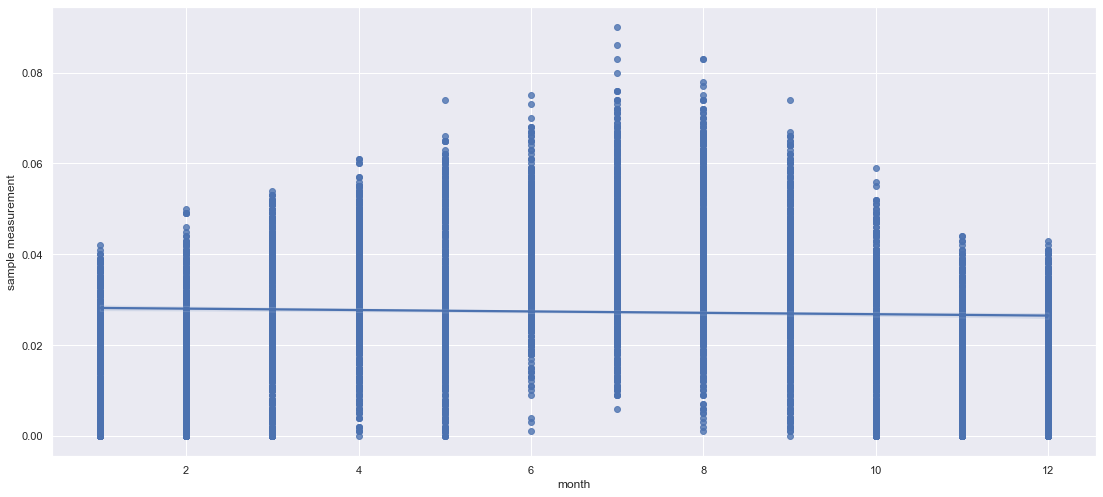

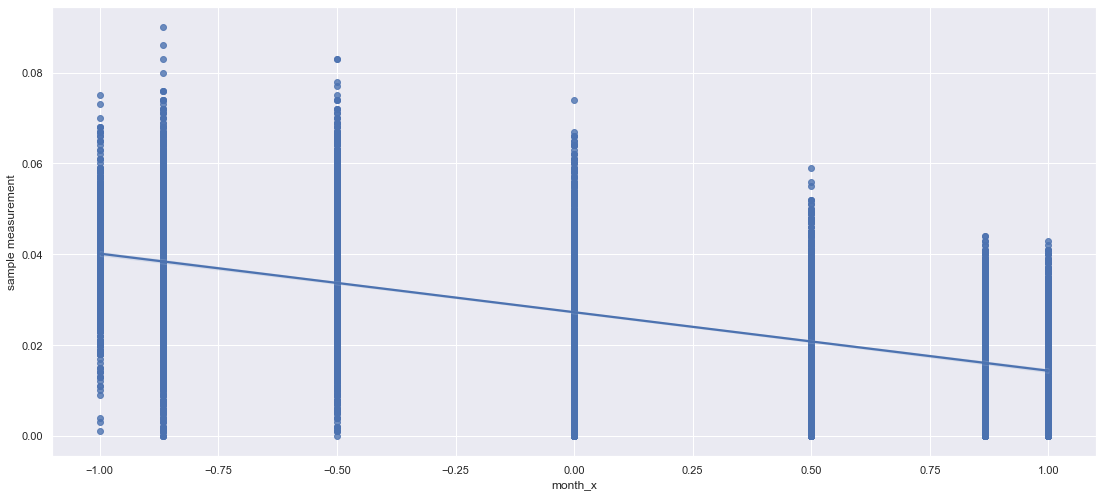

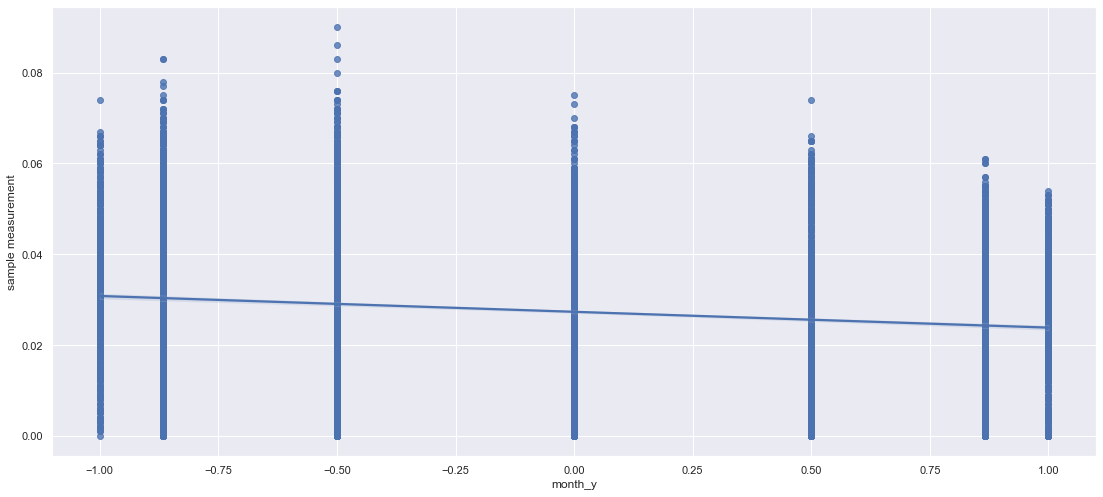

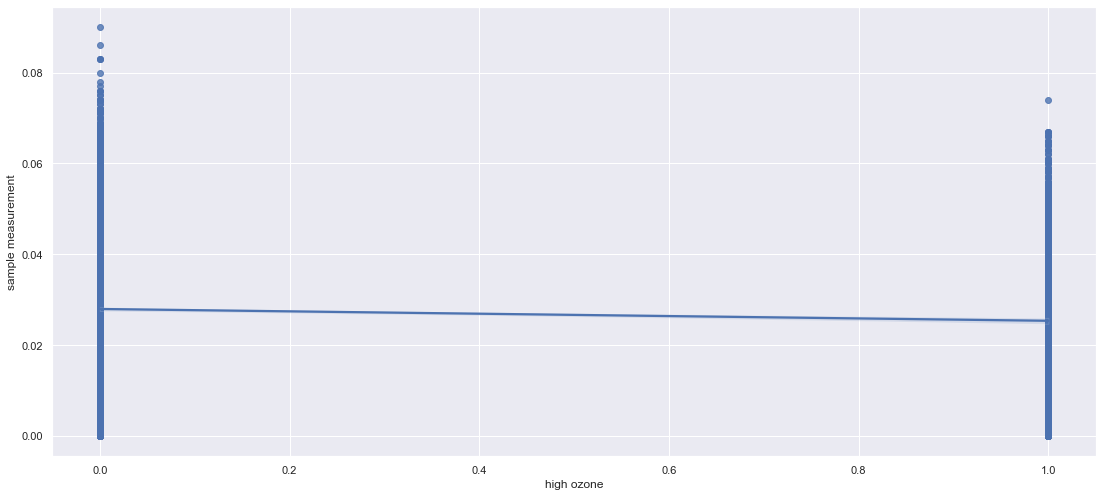

In [145]:
# Some regression plots against the target variable here. 
# Of these, ones that seem promising: temp, humidity, 
# 
numer_cols = [i for i in df_col.columns if df_col[i].dtype=='float64']
for i in numer_cols:
    plt.figure(i)
    ax = sns.regplot(x=i, y='sample measurement', data = df_col)

In [146]:
calculate_percent_missing(df_col)

,percent_missing
date local,0.000000
time local,0.000000
sample measurement,0.000000
datetime_oz,0.000000
name,0.011574
datetime_weather,0.011574
temp,0.011574
feelslike,0.011574
dew,0.011574
humidity,0.011574


In [147]:
df_col.head()

,date local,time local,sample measurement,datetime_oz,name,datetime_weather,temp,feelslike,dew,humidity,...,datetime_dt,day_of_week,type of day,hour,hour_x,hour_y,month,month_x,month_y,high ozone
0,2019-01-01,00:00,0.013,2019-01-01 00:00:00,"39.75, -104.987625",2019-01-01T00:00:00,0.9,-9.7,-1.6,88.81,...,2019-01-01 00:00:00,1.0,weekday,0.0,1.000000,0.000000,1.0,0.866025,0.5,0.0
1,2019-01-01,01:00,0.016,2019-01-01 01:00:00,"39.75, -104.987625",2019-01-01T01:00:00,0.1,-10.4,-3.1,86.21,...,2019-01-01 01:00:00,1.0,weekday,1.0,0.965926,0.258819,1.0,0.866025,0.5,0.0
2,2019-01-01,02:00,0.016,2019-01-01 02:00:00,"39.75, -104.987625",2019-01-01T02:00:00,0.2,-10.9,-2.9,86.25,...,2019-01-01 02:00:00,1.0,weekday,2.0,0.866025,0.500000,1.0,0.866025,0.5,0.0
3,2019-01-01,03:00,0.021,2019-01-01 03:00:00,"39.75, -104.987625",2019-01-01T03:00:00,0.5,-12.5,-2.7,85.95,...,2019-01-01 03:00:00,1.0,weekday,3.0,0.707107,0.707107,1.0,0.866025,0.5,0.0
4,2019-01-01,04:00,0.023,2019-01-01 04:00:00,"39.75, -104.987625",2019-01-01T04:00:00,0.4,-13.3,-3.0,85.06,...,2019-01-01 04:00:00,1.0,weekday,4.0,0.500000,0.866025,1.0,0.866025,0.5,0.0


In [148]:
# Selecting features based on visualizations from previous
use_cols_numerical=['temp', 'humidity', 'windspeed', 'month_x', 'month_y', 'sealevelpressure', 'hour_x', 'hour_y']
use_cols_cat = ['type of day']
target='sample measurement'
df_col_useful = df_col[use_cols_numerical + use_cols_cat + [target]]

In [149]:
df_col

,date local,time local,sample measurement,datetime_oz,name,datetime_weather,temp,feelslike,dew,humidity,...,datetime_dt,day_of_week,type of day,hour,hour_x,hour_y,month,month_x,month_y,high ozone
0,2019-01-01,00:00,0.013,2019-01-01 00:00:00,"39.75, -104.987625",2019-01-01T00:00:00,0.9,-9.7,-1.6,88.81,...,2019-01-01 00:00:00,1.0,weekday,0.0,1.000000,0.000000,1.0,0.866025,5.000000e-01,0.0
1,2019-01-01,01:00,0.016,2019-01-01 01:00:00,"39.75, -104.987625",2019-01-01T01:00:00,0.1,-10.4,-3.1,86.21,...,2019-01-01 01:00:00,1.0,weekday,1.0,0.965926,0.258819,1.0,0.866025,5.000000e-01,0.0
2,2019-01-01,02:00,0.016,2019-01-01 02:00:00,"39.75, -104.987625",2019-01-01T02:00:00,0.2,-10.9,-2.9,86.25,...,2019-01-01 02:00:00,1.0,weekday,2.0,0.866025,0.500000,1.0,0.866025,5.000000e-01,0.0
3,2019-01-01,03:00,0.021,2019-01-01 03:00:00,"39.75, -104.987625",2019-01-01T03:00:00,0.5,-12.5,-2.7,85.95,...,2019-01-01 03:00:00,1.0,weekday,3.0,0.707107,0.707107,1.0,0.866025,5.000000e-01,0.0
4,2019-01-01,04:00,0.023,2019-01-01 04:00:00,"39.75, -104.987625",2019-01-01T04:00:00,0.4,-13.3,-3.0,85.06,...,2019-01-01 04:00:00,1.0,weekday,4.0,0.500000,0.866025,1.0,0.866025,5.000000e-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2019-12-31,19:00,0.002,2019-12-31 19:00:00,"39.75, -104.987625",2019-12-31T19:00:00,31.1,23.4,8.2,37.63,...,2019-12-31 19:00:00,1.0,weekday,19.0,0.258819,-0.965926,12.0,1.000000,-2.449294e-16,0.0
8636,2019-12-31,20:00,0.003,2019-12-31 20:00:00,"39.75, -104.987625",2019-12-31T20:00:00,30.3,24.4,7.2,37.17,...,2019-12-31 20:00:00,1.0,weekday,20.0,0.500000,-0.866025,12.0,1.000000,-2.449294e-16,0.0
8637,2019-12-31,21:00,0.011,2019-12-31 21:00:00,"39.75, -104.987625",2019-12-31T21:00:00,31.8,23.9,5.3,32.11,...,2019-12-31 21:00:00,1.0,weekday,21.0,0.707107,-0.707107,12.0,1.000000,-2.449294e-16,0.0
8638,2019-12-31,22:00,0.022,2019-12-31 22:00:00,"39.75, -104.987625",2019-12-31T22:00:00,31.5,23.2,6.5,34.29,...,2019-12-31 22:00:00,1.0,weekday,22.0,0.866025,-0.500000,12.0,1.000000,-2.449294e-16,0.0


<AxesSubplot:>

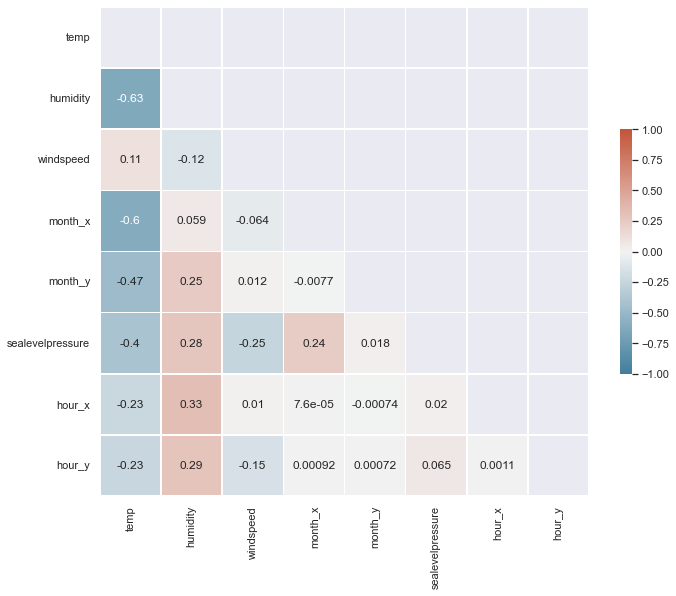

In [150]:
# Feature's don't look too correlated with one another.
corr = df_col[use_cols_numerical].corr()
mask = mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [151]:
# Only 1% data missing. Could try to forward fill this data, but I'll just remove it.
calculate_percent_missing(df_col_useful)

,percent_missing
temp,0.011574
humidity,0.011574
windspeed,0.011574
month_x,0.011574
month_y,0.011574
sealevelpressure,0.011574
hour_x,0.011574
hour_y,0.011574
type of day,0.000000
sample measurement,0.000000


In [152]:
df_col_useful = df_col_useful.dropna()

# 2. Linear Regression

In [153]:
df_use_num = df_col_useful[use_cols_numerical]
df_use_cat = df_col_useful[use_cols_cat]
y = df_col_useful[target]

In [154]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #scaling the parameters
ss = StandardScaler()
rs = RobustScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df_use_num), index=df_use_num.index, columns=use_cols_numerical)
#pd.pivot_table(df_scaled, index=['diabetes'],  values = df_scaled.columns, aggfunc = np.mean)

In [155]:
df_cat_encoded = pd.get_dummies(df_use_cat, drop_first = True)
df_cat_encoded

,type of day_weekend
0,0
1,0
2,0
3,0
4,0
...,...
8635,0
8636,0
8637,0
8638,0


In [156]:
from sklearn.model_selection import train_test_split
X = pd.concat([df_scaled, df_cat_encoded], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRACTION, random_state = RAND_STATE)

In [157]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.6282839029419833

In [158]:
print(get_mae(reg, X_test, y_test), get_rmse(reg, X_test, y_test))

0.008415888001073945 0.01044373477264728


# 3. Regular Polynomial Regression

In [159]:
use_cols_numerical=['temp', 'humidity', 'windspeed', 'month_x', 'month_y', 'sealevelpressure', 'hour_x', 'hour_y']
use_cols_cat = ['type of day']
target='sample measurement'
df_col_useful = df_col[use_cols_numerical + use_cols_cat + [target]]
df_col_useful.dropna(inplace=True)

/home/jcummings/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [160]:
df_col_useful

,temp,humidity,windspeed,month_x,month_y,sealevelpressure,hour_x,hour_y,type of day,sample measurement
0,0.9,88.81,5.2,0.866025,5.000000e-01,1030.8,1.000000,0.000000,weekday,0.013
1,0.1,86.21,4.9,0.866025,5.000000e-01,1030.9,0.965926,0.258819,weekday,0.016
2,0.2,86.25,5.4,0.866025,5.000000e-01,1031.2,0.866025,0.500000,weekday,0.016
3,0.5,85.95,7.1,0.866025,5.000000e-01,1030.5,0.707107,0.707107,weekday,0.021
4,0.4,85.06,7.6,0.866025,5.000000e-01,1029.6,0.500000,0.866025,weekday,0.023
...,...,...,...,...,...,...,...,...,...,...
8635,31.1,37.63,8.7,1.000000,-2.449294e-16,1012.8,0.258819,-0.965926,weekday,0.002
8636,30.3,37.17,5.8,1.000000,-2.449294e-16,1012.5,0.500000,-0.866025,weekday,0.003
8637,31.8,32.11,9.3,1.000000,-2.449294e-16,1011.1,0.707107,-0.707107,weekday,0.011
8638,31.5,34.29,9.8,1.000000,-2.449294e-16,1009.9,0.866025,-0.500000,weekday,0.022


In [161]:
df_col_useful["sealevelpressure"].max()

1038.2

In [162]:
N_DEG = 5
df_scaled_p, df_cat_p, y = get_poly_scaled(df_col_useful, use_cols_numerical, use_cols_cat, target, N_DEG)

In [163]:
df_cat_encoded = pd.get_dummies(df_cat_p, drop_first = True)
df_cat_encoded 

,type of day_weekend
0,0
1,0
2,0
3,0
4,0
...,...
8634,0
8635,0
8636,0
8637,0


In [164]:
from sklearn.model_selection import train_test_split
X = pd.concat([df_scaled_p, df_cat_encoded], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRACTION, random_state = RAND_STATE)
X

,1,temp,humidity,windspeed,month_x,month_y,sealevelpressure,hour_x,hour_y,temp^2,...,sealevelpressure hour_x^2 hour_y^2,sealevelpressure hour_x hour_y^3,sealevelpressure hour_y^4,hour_x^5,hour_x^4 hour_y,hour_x^3 hour_y^2,hour_x^2 hour_y^3,hour_x hour_y^4,hour_y^5,type of day_weekend
0,0.0,-2.360999,1.407423,-0.777965,1.229797,0.713593,2.315534,1.412402,0.001342,-1.357442,...,-1.413447,-0.000422,-1.029988,2.014649,0.001313,-0.001909,0.001446,-0.001174,0.000845,0
1,0.0,-2.399770,1.301506,-0.847856,1.229797,0.713593,2.329312,1.364191,0.367197,-1.357818,...,-0.694692,0.085694,-1.017475,1.693652,1.364805,0.556012,0.150868,0.025028,0.003184,0
2,0.0,-2.394924,1.303135,-0.731370,1.229797,0.713593,2.370647,1.222844,0.708118,-1.357804,...,0.743445,0.556403,-0.855653,0.980230,1.703369,1.498747,0.867430,0.326018,0.063781,0
3,0.0,-2.380385,1.290914,-0.335318,1.229797,0.713593,2.274199,0.997993,1.000875,-1.357706,...,1.460456,1.284637,-0.333119,0.354242,1.071122,1.631798,1.634361,1.067428,0.356867,0
4,0.0,-2.385231,1.254658,-0.218833,1.229797,0.713593,2.150195,0.704961,1.225515,-1.357748,...,0.740098,1.667461,0.536599,0.060720,0.328874,0.864495,1.501374,1.698962,0.981927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8634,0.0,-0.897407,-0.677520,0.037436,1.418630,0.004053,-0.164558,0.363719,-1.364045,-0.903023,...,-0.707312,-1.178804,1.354869,0.000033,-0.024917,0.147585,-0.556204,1.360780,-1.692602,0
8635,0.0,-0.936178,-0.696259,-0.638182,1.418630,0.004053,-0.205893,0.704961,-1.222830,-0.926120,...,0.704331,-1.640603,0.510581,0.060720,-0.326247,0.864495,-1.498482,1.698962,-0.980238,0
8636,0.0,-0.863483,-0.902390,0.177219,1.418630,0.004053,-0.398789,0.997993,-0.998190,-0.882319,...,1.406353,-1.261288,-0.346238,0.354242,-1.068496,1.631798,-1.631468,1.067428,-0.355178,0
8637,0.0,-0.878022,-0.813583,0.293705,1.418630,0.004053,-0.564128,1.222844,-0.705434,-0.891248,...,0.698893,-0.545745,-0.859254,0.980230,-1.700742,1.498747,-0.864537,0.326018,-0.062092,0


In [165]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.8300950054551849

In [166]:
reg.score(X_test, y_test)

0.7562008538398861

In [167]:
#print(get_mae(reg, X_test, y_test), get_rmse(reg, X_test, y_test))
print_errors(reg, X_test, y_test)

MAE: 0.0064 
RMSE: 0.0085


In [168]:
print_errors(reg, X_train, y_train)

MAE: 0.0054 
RMSE: 0.0069


In [185]:
# As a very baseline, let's take a look at the histograms of the predicted model and actual model
# A couple improvements I'd like to make is I'd like to capture the tail of this distribution better
# I think that importing a custom loss function to penalize the error made at higher ozone levels could be helpful here.
# There is also the issue of predicting negative ozone levels. However, this is not as 
# concerning to me as we can consider those to be zero. However, having the ability capture the large amount of 
# very low ozone cases would be 
fig, ax = plt.subplots(1,2, sharey=True, sharex = True)
sns.set(rc={'figure.figsize':(18.7,8.27)})
sns.histplot(y, stat='probability', bins=15, legend=False, ax=ax[0]).set_title('true ozone level')
sns.histplot(reg.predict(X), stat='probability', bins=15, legend=False, ax=ax[1]).set_title('predicted')

# 4. Ridge Polynomial Regression

In [169]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
alpha = np.linspace(.05, .5, 50)
ridge_params = {'alpha':alpha}
reg_ridge = linear_model.Ridge()
grid_ridge = GridSearchCV(reg_ridge, param_grid=ridge_params, scoring='neg_mean_absolute_error', cv=CV, n_jobs=N_JOBS, verbose=2)
grid_ridge.fit(X_train, y_train)

Fitting 7 folds for each of 50 candidates, totalling 350 fits


GridSearchCV(cv=7, estimator=Ridge(), n_jobs=7,
             param_grid={'alpha': array([0.05      , 0.05918367, 0.06836735, 0.07755102, 0.08673469,
       0.09591837, 0.10510204, 0.11428571, 0.12346939, 0.13265306,
       0.14183673, 0.15102041, 0.16020408, 0.16938776, 0.17857143,
       0.1877551 , 0.19693878, 0.20612245, 0.21530612, 0.2244898 ,
       0.23367347, 0.24285714, 0.25204082, 0.26122449, 0.27040816,
       0.27959184, 0.28877551, 0.29795918, 0.30714286, 0.31632653,
       0.3255102 , 0.33469388, 0.34387755, 0.35306122, 0.3622449 ,
       0.37142857, 0.38061224, 0.38979592, 0.39897959, 0.40816327,
       0.41734694, 0.42653061, 0.43571429, 0.44489796, 0.45408163,
       0.46326531, 0.47244898, 0.48163265, 0.49081633, 0.5       ])},
             scoring='neg_mean_absolute_error', verbose=2)

In [170]:
-grid_ridge.score(X_test, y_test)

0.0066566806427915655

In [171]:
print('Best Params: {}, \n Best score: {:.2f}'.format(grid_ridge.best_params_, grid_ridge.best_score_))

Best Params: {'alpha': 0.07755102040816328}, 
 Best score: -0.01


In [172]:
print_errors(grid_ridge, X_test, y_test)

MAE: 0.0067 
RMSE: 0.0085


In [173]:
print_errors(grid_ridge, X_train, y_train)

MAE: 0.0060 
RMSE: 0.0077


In [181]:
import pickle
pickle.dump(grid_ridge, open("model.pkl", "wb"))

Text(0.5, 1.0, 'predicted')

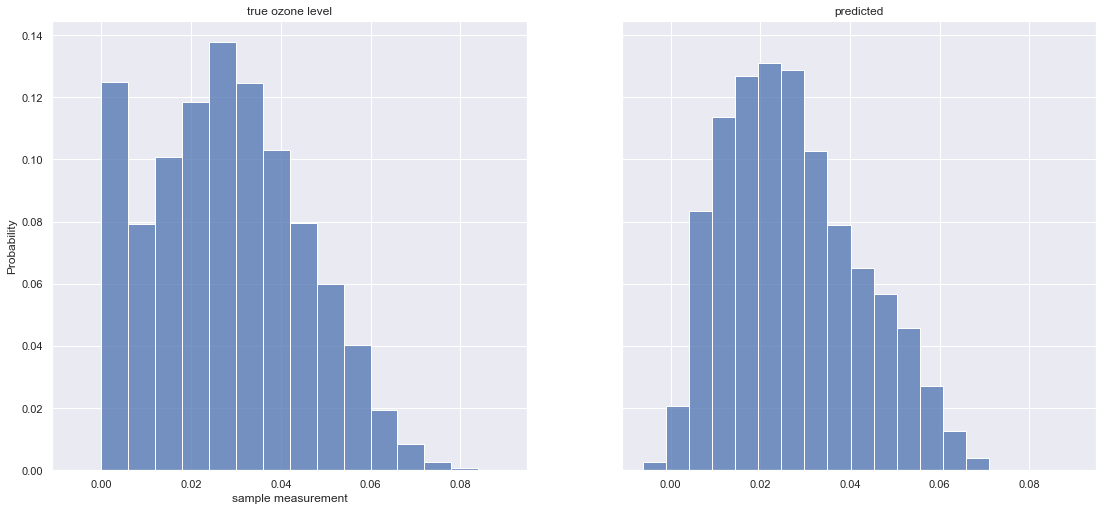

In [189]:
# As a very baseline, let's take a look at the histograms of the predicted model and actual model
# A couple improvements I'd like to make is I'd like to capture the tail of this distribution better
# I think that importing a custom loss function to penalize the error made at higher ozone levels could be helpful here.
# There is also the issue of predicting negative ozone levels. However, this is not as 
# concerning to me as we can consider those to be zero. However, having the ability capture the large amount of 
# very low ozone cases would be 
fig, ax = plt.subplots(1,2, sharey=True, sharex = True)
sns.set(rc={'figure.figsize':(18.7,8.27)})
BINS = 15
sns.histplot(y, stat='probability', bins=BINS, legend=False, ax=ax[0]).set_title('true ozone level')
sns.histplot(grid_ridge.predict(X), stat='probability', bins=BINS, legend=False, ax=ax[1]).set_title('predicted')

#sns.histplot(reg.predict(X), multiple='dodge')

In [175]:
def cyclicize(in_series, T):
    """ Transforms a variable into a cylcic variable with period T by
    doing cos(2pi/T x), sin(2pi/T x). Will work for a series as well as a number"""

    cyclic_x = np.cos(2*np.pi/T * in_series)
    cyclic_y = np.sin(2*np.pi/T * in_series)

    return cyclic_x, cyclic_y

def predict(input_dict):
    import pickle
    """ returns the predicted ozone pollution ppm based on input variables """
    poly_pickle = pickle.load(open("poly.pkl", "rb"))
    scaler_pickle = pickle.load(open("scaler.pkl", "rb"))
    model_pickle = pickle.load(open("model.pkl", "rb"))

    hour_x, hour_y = cyclicize(input_dict["hour"], 24)
    month_x, month_y = cyclicize(input_dict["month"], 12)

    input_dict_num = {
        "temp": [input_dict["temp"]],
        "humidity": [input_dict["humidity"]],
        "windspeed": [input_dict["windspeed"]],
        "month_x": [month_x],
        "month_y": [month_y],
        "sea_level_pressure": [input_dict["sea_level_pressure"]],
        "hour_x": [hour_x],
        "hour_y": [hour_y]
    }
    
    print(df_col_useful.iloc[0])

    input_dict_cat = {"is_weekend": [input_dict["is_weekend"]]}
    #print(input_dict_num.keys())
    input_series_num = pd.DataFrame.from_dict(input_dict_num)
    input_series_cat = pd.DataFrame.from_dict(input_dict_cat)

    print(input_series_num)

    poly_series = poly_pickle.transform(input_series_num)
    scaled_poly_series = scaler_pickle.transform(poly_series)
    df_poly = pd.DataFrame(scaled_poly_series)
    df_poly.columns = poly_pickle.get_feature_names(input_series_num.columns)
    print(scaled_poly_series)

    input_series = pd.concat([df_poly, input_series_cat], axis=1)
    print(input_series)
    prediction = model_pickle.predict(input_series)
    print(prediction)

In [183]:
input_dictionary = {
    "temp": 80,
    "humidity": 0,
    "windspeed": 0,
    "month": 6,
    "sea_level_pressure": 1008.8,
    "hour": 18,
    "is_weekend": 1
}
pred = predict(input_dictionary)

temp                       0.9
humidity                 88.81
windspeed                  5.2
month_x               0.866025
month_y                    0.5
sealevelpressure        1030.8
hour_x                       1
hour_y                       0
type of day            weekday
sample measurement       0.013
Name: 0, dtype: object
   temp  humidity  windspeed  month_x       month_y  sea_level_pressure  \
0    80         0          0     -1.0  1.224647e-16              1008.8   

         hour_x  hour_y  
0 -1.836970e-16    -1.0  
[[ 0.00000000e+00  1.47244903e+00 -2.21047003e+00 ...  1.44626356e-03
  -1.17354097e-03 -2.01312333e+00]]
     1      temp  humidity  windspeed   month_x   month_y  sea_level_pressure  \
0  0.0  1.472449  -2.21047  -1.989417 -1.400306  0.004053            -0.71569   

    hour_x   hour_y    temp^2  ...  sea_level_pressure hour_x^2 hour_y^2  \
0 -0.00248 -1.41221  1.651578  ...                             -1.413447   

   sea_level_pressure hour_x hour_y^3  sea